### Постановка бизнес-задачи

Проанализировать данные о торговых точках Старбакс в Москве и выделить кластер наименнее эффективных точек. Оценить влияние на выручку, маржинальность и удовлетворенность клиентов закрытия неэффективного кластера

### Загрузка и предобработка данных

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, cluster
import scipy

import folium
import geopy

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv("Lesson_5.csv")

In [5]:
df.head(3)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39


In [ ]:
del df["State/Province"]
del df["Postcode"]
del df["Phone Number"]
del df["Store Name"]

In [8]:
df.head(3)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,AD,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.39


In [14]:
df["Store Number"].value_counts().sort_values(ascending=False)

19773-160973    2
20281-150104    1
12130-15520     1
441-159826      1
12727-155291    1
               ..
3937-128705     1
1354-141273     1
75298-99911     1
26904-246108    1
20115-185804    1
Name: Store Number, Length: 25599, dtype: int64

In [15]:
df.loc[df['Store Number'] == "19773-160973"]

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
8028,Starbucks,19773-160973,Yoido IFC Mall - 1F,Joint Venture,"23 & 23-1, Yoido-Dong, Yongdongpo-Gu, 1F, #101",Seoul,KR,GMT+09:00 Asia/Seoul,NaN,NaN
8159,Starbucks,19773-160973,Yoido IFC Mall - 1F,Joint Venture,"23 & 23-1, Yoido-Dong, Yongdongpo-Gu, 1F, #101",Seoul,KR,GMT+09:00 Asia/Seoul,126.92,37.53


In [26]:
np.where(df['Store Number'] == "19773-160973") and np.where(pd.isna(df['Longitude']) == True)[0]

array([8028], dtype=int64)

In [27]:
df = df.drop(np.where(df['Store Number'] == "19773-160973") and np.where(pd.isna(df['Longitude']) == True)[0])

In [28]:
df["Store Number"].value_counts().sort_values(ascending=False)

33734-83811     1
12218-33459     1
441-159826      1
12727-155291    1
4411-9638       1
               ..
3937-128705     1
1354-141273     1
75298-99911     1
26904-246108    1
28884-251781    1
Name: Store Number, Length: 25599, dtype: int64

In [29]:
df.set_index(df["Store Number"], inplace = True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25599 entries, 47370-257954 to 47609-253286
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Brand           25599 non-null  object 
 1   Store Number    25599 non-null  object 
 2   Store Name      25599 non-null  object 
 3   Ownership Type  25599 non-null  object 
 4   Street Address  25599 non-null  object 
 5   City            25599 non-null  object 
 6   Country         25599 non-null  object 
 7   Timezone        25599 non-null  object 
 8   Longitude       25599 non-null  float64
 9   Latitude        25599 non-null  float64
dtypes: float64(2), object(8)
memory usage: 2.1+ MB


In [31]:
df.loc[pd.isna(df['Street Address']) == True]

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
Store Number,,,,,,,,,,
30997-103902,Starbucks,30997-103902,베네시티점,Joint Venture,NaN,부산,KR,GMT+09:00 Asia/Seoul,129.15,35.16
1329-152826,Starbucks,1329-152826,광주충장로점,Joint Venture,NaN,광주,KR,GMT+09:00 Asia/Seoul,126.91,35.15


In [32]:
df.loc[pd.isna(df['City']) == True]

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude
Store Number,,,,,,,,,,
31657-104436,Starbucks,31657-104436,سان ستيفانو,Licensed,طريق الكورنيش أبراج سان ستيفانو,NaN,EG,GMT+2:00 Africa/Cairo,29.96,31.24
32152-109504,Starbucks,32152-109504,النايل سيتى,Licensed,كورنيش النيل أبراج النايل سيتى,NaN,EG,GMT+2:00 Africa/Cairo,31.23,30.07
32314-115172,Starbucks,32314-115172,أسكندرية الصحراوى,Licensed,"الكيلو 28 طريق الاسكندرية الصحراوى, سيتى سنتر ...",NaN,EG,GMT+2:00 Africa/Cairo,31.03,30.06
31479-105246,Starbucks,31479-105246,مكرم عبيد,Licensed,"شارع مكرم عبيد, سيتى ستارز مول",NaN,EG,GMT+2:00 Africa/Cairo,31.34,30.09
31756-107161,Starbucks,31756-107161,سيتى ستارز 1,Licensed,"شارع عمر بن الخطاب, سيتى ستارز مول",NaN,EG,GMT+2:00 Africa/Cairo,31.33,30.06
1397-139244,Starbucks,1397-139244,سيتى ستارز 3,Licensed,"شارع عمر بن الخطاب, كارفور المعادى",NaN,EG,GMT+2:00 Africa/Cairo,31.33,30.06
32191-116645,Starbucks,32191-116645,معادى سيتى سنتر,Licensed,القطامية الطريق الدائرى,NaN,EG,GMT+2:00 Africa/Cairo,31.30,29.99
3664-142484,Starbucks,3664-142484,سليمان أباظة,Licensed,"34شارع سليمان أباظة المهندسين, تيفولى مول",NaN,EG,GMT+2:00 Africa/Cairo,31.20,30.06
3562-131562,Starbucks,3562-131562,تيفولى,Licensed,"ألماظة ميدان الجوهر شارع أحمد فوزى, صالة السفر 1",NaN,EG,GMT+2:00 Africa/Cairo,31.34,30.08


In [33]:
df.fillna("No_data", inplace = True)

### EDA

In [35]:
!pip install sweetviz

In [38]:
import sweetviz as sv

In [39]:
feature_config = sv.FeatureConfig(skip=["Store Number", "Store Name", "Street Address" ])


In [40]:
report = sv.analyze(df, feat_cfg = feature_config)

report.show_html('Lesson_5_report.html')


Report Lesson_5_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Добавление показателей эффективности кофеен

In [63]:
df["Revenue"] = np.random.randint(low=150000, high=250000, size=len(df))
df["Cost"] = np.random.randint(low=120000, high=210000, size=len(df))
df["Satisfaction"] = np.random.choice(["Very_satisfied", "Satisfied", "Neither", "Dissatisfied", "Very dissatisfied"], size=len(df), p=[0.4,0.4,0.1,0.07, 0.03])

In [71]:
df.head(3)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Potential,Staff,Capacity,Cost,Revenue,Satisfaction
Store Number,,,,,,,,,,,,,,,,
47370-257954,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,AD,GMT+1:00 Europe/Andorra,1.53,42.51,3,3,0,152782,151430,Very_satisfied
22331-212325,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.42,6,2,4,165815,241406,Satisfied
47089-256771,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AE,GMT+04:00 Asia/Dubai,55.47,25.39,9,8,1,183582,188382,Very_satisfied


In [66]:
city = "Moscow"

locator = geopy.geocoders.Nominatim(user_agent="Lesson_5")
location = locator.geocode(city)
location = [location.latitude, location.longitude]

In [110]:
Moscow_df = df.loc[df['City'] == "Moscow"]

In [117]:
Moscow_df["Country"].value_counts()

RU    74
US     3
Name: Country, dtype: int64

In [118]:
Moscow_df.loc[Moscow_df['Country'] == "US"]

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Potential,Staff,Capacity,Cost,Revenue,Satisfaction
Store Number,,,,,,,,,,,,,,,,
79663-115245,Starbucks,79663-115245,Safeway - Moscow #383,Licensed,1320 Blaine St,Moscow,US,GMT-08:00 America/Los_Angeles,-116.98,46.72,4,1,3,155624,248221,Very_satisfied
3760-126584,Starbucks,3760-126584,The University of Idaho - VandalSto,Licensed,710 S Deakin St,Moscow,US,GMT-08:00 America/Los_Angeles,-117.01,46.73,9,5,4,155343,193505,Very_satisfied
3357-166484,Starbucks,3357-166484,Palouse Mall - Moscow,Company Owned,1930 West Pullman Road,Moscow,US,GMT-08:00 America/Los_Angeles,-117.03,46.73,10,4,6,185262,191723,Very_satisfied


In [119]:
Moscow_df = Moscow_df.loc[df['Country'] == "RU"]

In [101]:
Moscow_map = folium.Map(location=location, zoom_start=10)

In [102]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
Moscow_df["size"] = scaler.fit_transform(Moscow_df["Revenue"].values.reshape(-1,1)).reshape(-1)

for index, row in Moscow_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    
    if row["Revenue"] < row["Cost"]:
        current_color = "red"
    else:
        current_color = "green"
        
    
    folium.CircleMarker(location=current_location, fill=True, color = current_color , radius = row['size'] ).add_to(Moscow_map)

In [103]:
Moscow_map

In [104]:
Moscow_df.head(3)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Potential,Staff,Capacity,Cost,Revenue,Satisfaction,size
Store Number,,,,,,,,,,,,,,,,,
18904-138404,Starbucks,18904-138404,Krasnaya Roza,Joint Venture,"Timura Frunze St 11, Khamovniki District",Moscow,RU,GMT+3:00 Europe/Moscow,37.59,55.73,3,1,2,125947,186641,Satisfied,7.098675
1562-152965,Starbucks,1562-152965,Auchan Troyka SM Ground Floor,Joint Venture,"Verkhnaya Krasnosel'skaya street 3A, Baumansky 61",Moscow,RU,GMT+3:00 Europe/Moscow,37.67,55.78,10,5,5,167328,164749,Very_satisfied,4.358465
3011-138431,Starbucks,3011-138431,SEC Mall of Russia,Joint Venture,"Presnenskaya nab., 2, Ground Floor",Moscow,RU,GMT+3:00 Europe/Moscow,37.54,55.75,6,3,3,120730,167413,Satisfied,4.691916


### Кластеризация

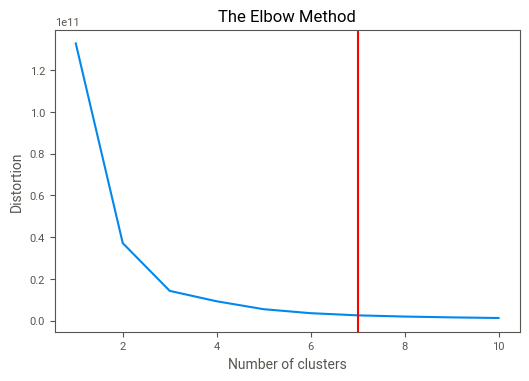

In [155]:
Moscow_df['Profit'] = Moscow_df['Revenue'] - Moscow_df['Cost']
Moscow_df['Satisfaction'] = Moscow_df['Satisfaction'].map({"Very_satisfied": 10, "Satisfied":6, "Neither" : 4, "Dissatisfied": 2, "Very dissatisfied": 1})

X = Moscow_df[["Satisfaction","Profit"]]
max_k = 10


distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
        model = KMeans(n_clusters=i, max_iter=300, n_init=10)
        model.fit(X)
        distortions.append(model.inertia_)
    

k = [i*100 for i in np.diff(distortions, 2)].index(min([i*100 for i in np.diff(distortions,2)]))


fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='-', color="red", label="k = " + str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', ylabel="Distortion")

plt.show()

In [156]:
k = 7
model = KMeans(n_clusters=k)

X = Moscow_df[["Satisfaction","Profit"]]
Moscow_df["cluster"] = model.fit_predict(X)

In [157]:
Moscow_df.head(3)

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,Country,Timezone,Longitude,Latitude,Potential,Staff,Capacity,Cost,Revenue,Satisfaction,cluster,size,Profit
Store Number,,,,,,,,,,,,,,,,,,,
18904-138404,Starbucks,18904-138404,Krasnaya Roza,Joint Venture,"Timura Frunze St 11, Khamovniki District",Moscow,RU,GMT+3:00 Europe/Moscow,37.59,55.73,3,1,2,125947,186641,6,4,7.098675,60694
1562-152965,Starbucks,1562-152965,Auchan Troyka SM Ground Floor,Joint Venture,"Verkhnaya Krasnosel'skaya street 3A, Baumansky 61",Moscow,RU,GMT+3:00 Europe/Moscow,37.67,55.78,10,5,5,167328,164749,10,5,4.358465,-2579
3011-138431,Starbucks,3011-138431,SEC Mall of Russia,Joint Venture,"Presnenskaya nab., 2, Ground Floor",Moscow,RU,GMT+3:00 Europe/Moscow,37.54,55.75,6,3,3,120730,167413,6,4,4.691916,46683


In [158]:
new_moscow_map = folium.Map(location=location, zoom_start=10)

In [159]:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
Moscow_df["size"] = scaler.fit_transform(Moscow_df["Revenue"].values.reshape(-1,1)).reshape(-1)
color_dict = {0: 'green', 1: "red", 2:"orange", 3:"blue", 4: "yellow", 5:"black", 6:"grey"}

for index, row in Moscow_df.iterrows():
    current_location = [row['Latitude'], row['Longitude']]
    current_color = color_dict[row['cluster']]
    folium.CircleMarker(location=current_location, fill=True, color = current_color , radius = row['size'] ).add_to(new_moscow_map)

In [168]:
new_moscow_map

In [189]:
columns = ["Cluster", "Average_Revenue", "Sum_Revenue", "Average_Profit", "Sum_Profit", "Average_Satisfaction"]
result_df = pd.DataFrame(columns = columns)
for i in set(Moscow_df['cluster']):
    cluster_df = Moscow_df.loc[Moscow_df['cluster'] == i]
    result_df.loc[i] = [i, cluster_df["Revenue"].mean(), cluster_df["Revenue"].sum(), cluster_df["Profit"].mean(), cluster_df["Profit"].sum(), cluster_df["Satisfaction"].mean()]
 

In [188]:
result_df

,Cluster,Average_Revenue,Sum_Revenue,Average_Profit,Sum_Profit,Average_Satisfaction
0,0.0,238761.545455,2626377.0,103560.818182,1139169.0,7.636364
1,1.0,199295.181818,2192247.0,33455.909091,368015.0,7.454545
2,2.0,169218.000000,1861398.0,-24395.545455,-268351.0,7.272727
3,3.0,227267.000000,1818136.0,75229.750000,601838.0,8.500000
4,4.0,203238.818182,2235627.0,51352.181818,564874.0,8.181818
5,5.0,182289.538462,2369764.0,-3687.538462,-47938.0,6.615385
6,6.0,191490.777778,1723417.0,12673.222222,114059.0,7.111111


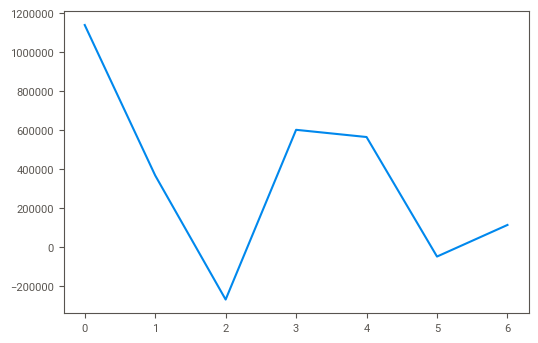

In [198]:
plt.plot(result_df["Cluster"], result_df["Sum_Profit"])

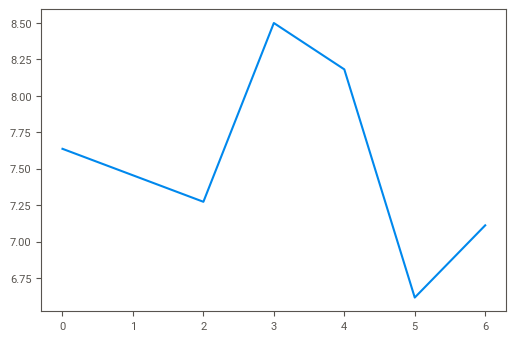

In [199]:
plt.plot(result_df["Cluster"], result_df["Average_Satisfaction"])

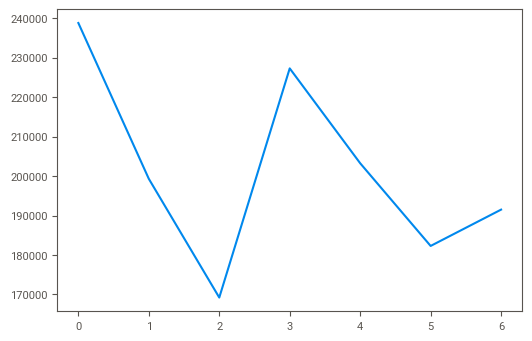

In [200]:
plt.plot(result_df["Cluster"], result_df["Average_Revenue"])

### Итоговое сравнение

#### До оптимизации

In [223]:
print("Выручка сети: %.2f  " % Moscow_df["Revenue"].sum())
print("Прибыль сети: %.2f " % Moscow_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % Moscow_df["Satisfaction"].mean())

Выручка сети: 14826966.00  
Прибыль сети: 2471666.00 
Средняя удовлетворенность клиента: 7.49 


#### После оптимизации

In [225]:
after_optimisation_df = Moscow_df.loc[Moscow_df["cluster"] != 2]

print("Выручка сети: %.2f " % after_optimisation_df["Revenue"].sum())
print("Прибыль сети: %.2f " % after_optimisation_df["Profit"].sum())
print("Средняя удовлетворенность клиента: %.2f " % after_optimisation_df["Satisfaction"].mean())

Выручка сети: 12965568.00 
Прибыль сети: 2740017.00 
Средняя удовлетворенность клиента: 7.52 


### Самостоятельный кейс №5

Измените модель таким образом, чтобы построить кластеры для оптимизации сети по всей России.

Правовая оговорка. Товарный знак Старбакс, упоминающийся в данном уроке, защищен как объект авторского права. Товарный знак Старбакс принадлежит Старбакс и/или его филиалам и аффилированным лицам или иным лицам, которые передали право на свои материалы Старбакс. Информация о расположении кофеен является публично доступной и не является коммерческой тайной Старбакс и/или его филиалов и аффилированных лиц или иных лиц, которые связаны с Старбакс. Информация о посещаемости кофеен, эффективности точек, количестве сотрудников и других производных показателях бизнеса является случайно сгенерированной (вымышленной) и не может быть использована для проведения анализа деятельности и/или быть основой для принятия каких либо решений, в том числе об открытии и/или закрытии позиций на фондовых и срочных рынках в любых странах. Старбакс в России - ООО «Кофе Сирена» 125040, г. Москва, ул. Правды, дом 26 ОГРН 5077746299560 ИНН 7714685546